In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Load datasets
df = pd.read_csv('SalesForecasting.csv')

# Display the first few rows of the dataset
print(df.head())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [3]:
# Handle missing values: For simplicity, let's fill missing Postal Codes with a placeholder value (e.g., -1)
df['Postal Code'].fillna(-1, inplace=True)

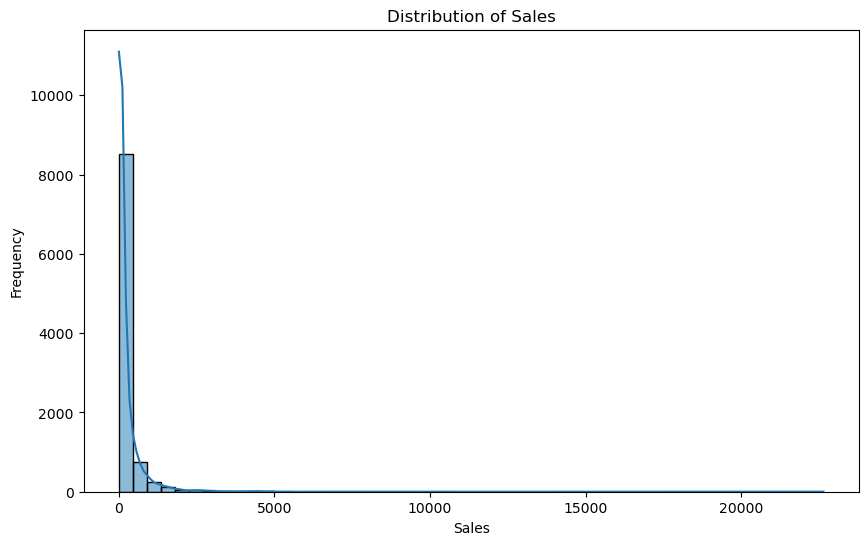

In [4]:
# Visualize the distribution of sales
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

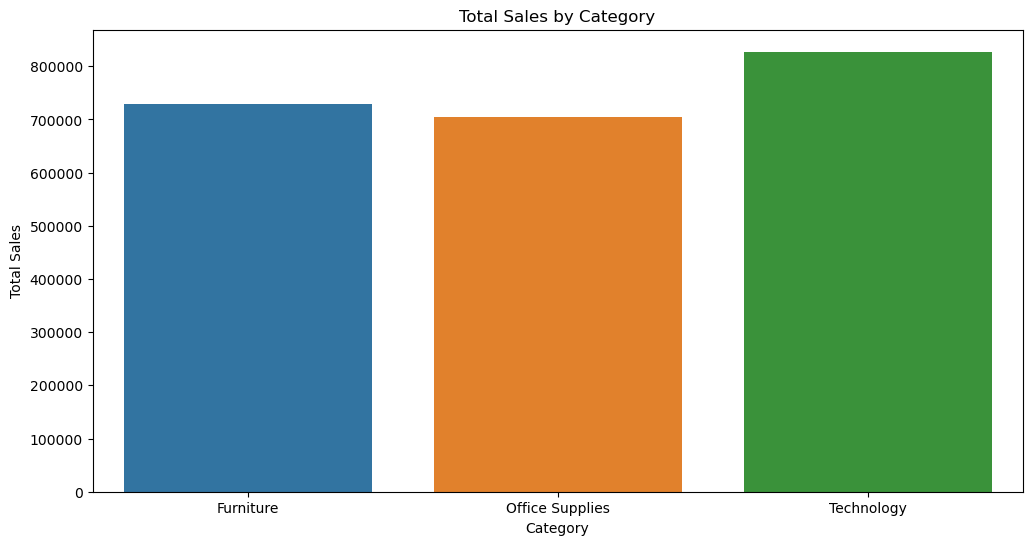

In [5]:
# Visualize sales by category
plt.figure(figsize=(12, 6))
category_sales = df.groupby('Category')['Sales'].sum().reset_index()
sns.barplot(x='Category', y='Sales', data=category_sales)
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.show()

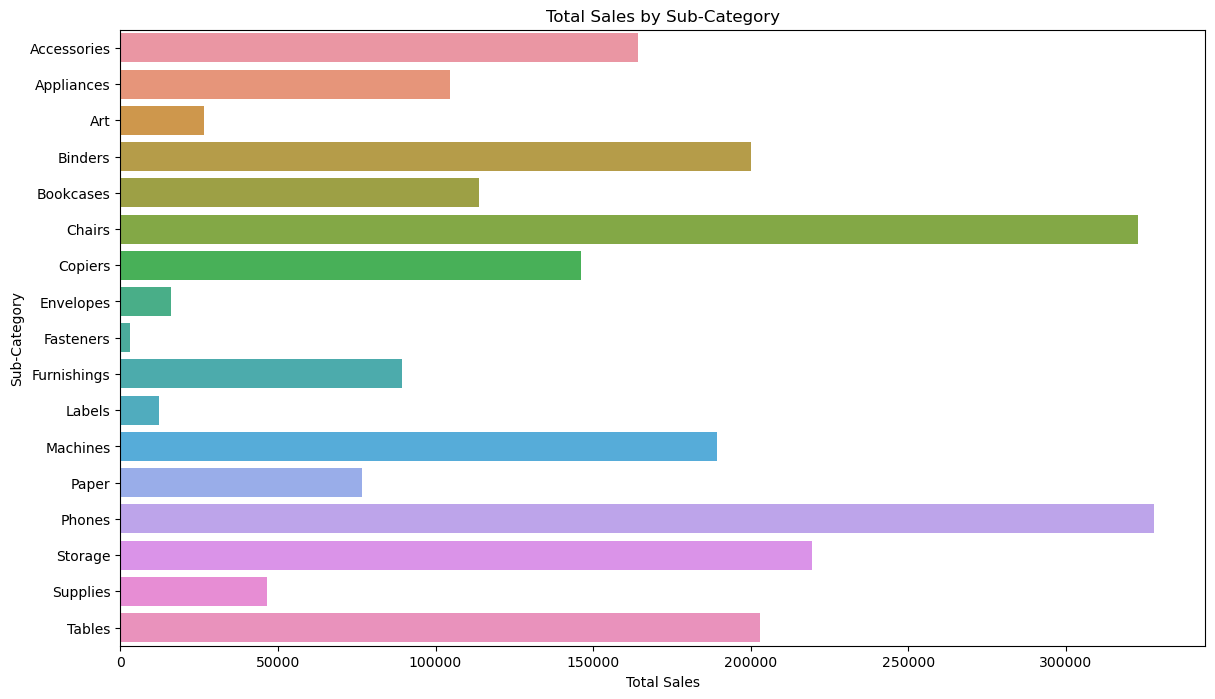

In [6]:
# Visualize sales by sub-category
plt.figure(figsize=(14, 8))
subcategory_sales = df.groupby('Sub-Category')['Sales'].sum().reset_index()
sns.barplot(x='Sales', y='Sub-Category', data=subcategory_sales)
plt.title('Total Sales by Sub-Category')
plt.xlabel('Total Sales')
plt.ylabel('Sub-Category')
plt.show()

In [7]:
# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

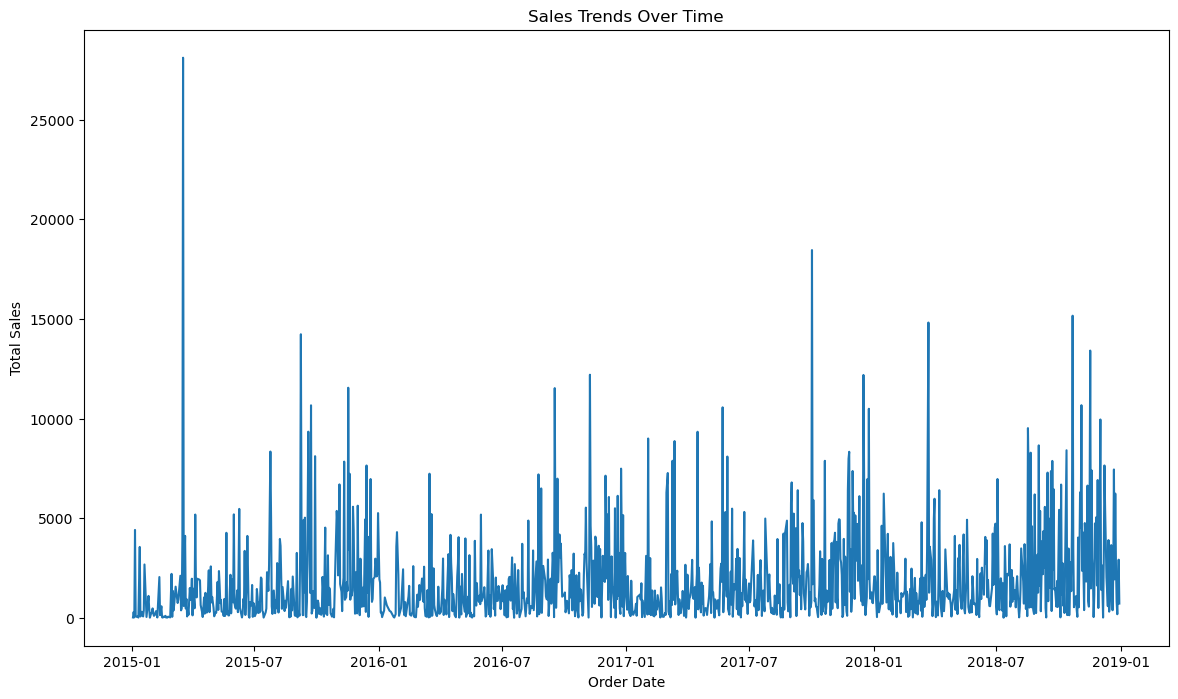

In [8]:
# Visualize sales trends over time
plt.figure(figsize=(14, 8))
time_series = df.groupby('Order Date')['Sales'].sum().reset_index()
sns.lineplot(x='Order Date', y='Sales', data=time_series)
plt.title('Sales Trends Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.show()

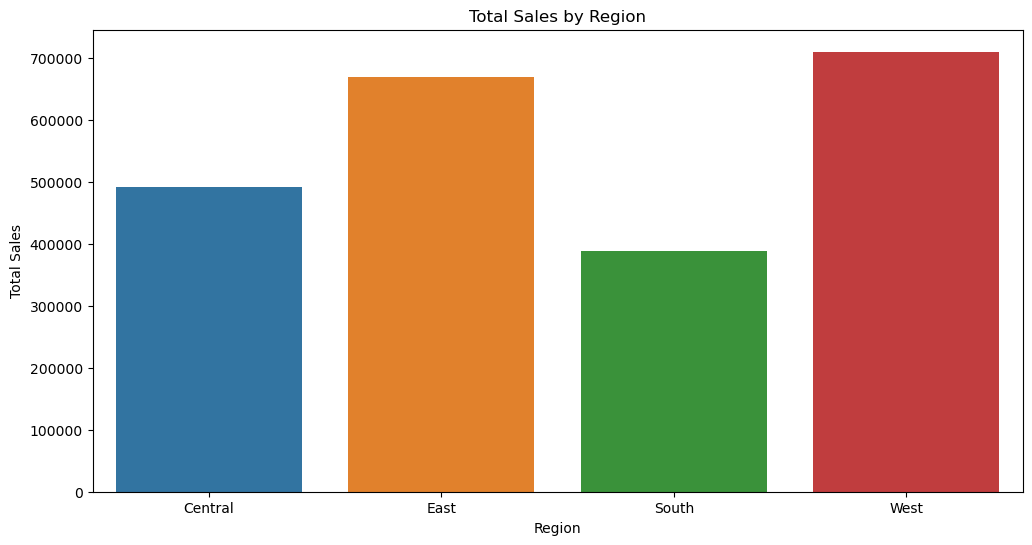

In [9]:
# Visualize sales by region
plt.figure(figsize=(12, 6))
region_sales = df.groupby('Region')['Sales'].sum().reset_index()
sns.barplot(x='Region', y='Sales', data=region_sales)
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.show()

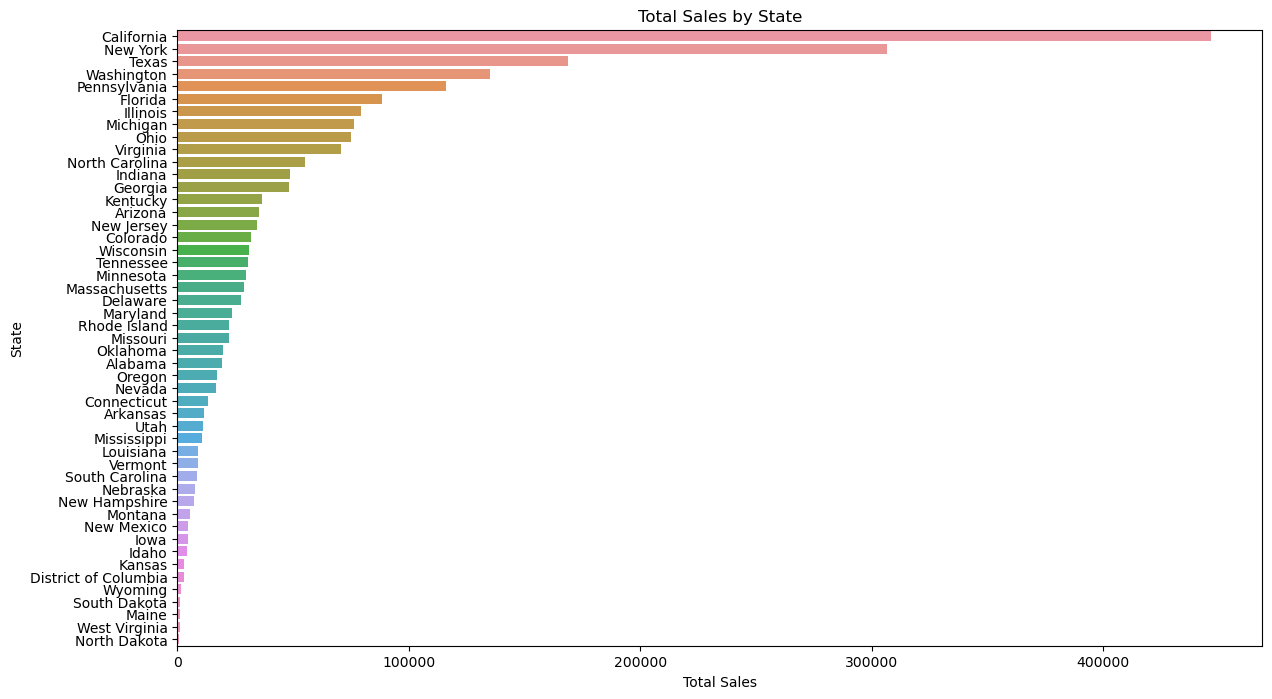

In [10]:
# Visualize sales by state
plt.figure(figsize=(14, 8))
state_sales = df.groupby('State')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)
sns.barplot(x='Sales', y='State', data=state_sales)
plt.title('Total Sales by State')
plt.xlabel('Total Sales')
plt.ylabel('State')
plt.show()

## Insights and Findings:

### Distribution of Sales:
* The sales distribution is highly right-skewed, indicating that most sales transactions are of lower value, with a few high-value transactions. This suggests a potential long-tail effect in the sales data.

### Total Sales by Category:
* The dataset shows three main product categories: Furniture, Office Supplies, and Technology.
* Office Supplies and Technology have significantly higher total sales compared to Furniture, indicating they are the major contributors to the overall sales.

### Total Sales by Sub-Category:
* Within the sub-categories, certain products like Binders, Paper, and Phones have higher total sales, reflecting their popularity and frequent purchases.
* On the other hand, products like Fasteners, Labels, and Envelopes have lower total sales.

### Sales Trends Over Time:
* The time series analysis of sales shows fluctuations, indicating variability in sales across different periods.
* There might be visible trends or seasonal patterns (e.g., higher sales during certain months or quarters), but a more detailed time series analysis would be required to confirm this.

### Total Sales by Region:
* The sales are distributed across different regions, with the West and East regions having higher total sales compared to the Central and South regions. This could indicate that the West and East regions are more lucrative markets.

### Total Sales by State:
* Certain states like California, New York, and Texas have the highest total sales, which might be due to larger populations or higher demand in these states.
* States with lower sales could represent opportunities for market expansion or targeted marketing efforts.